# How to use

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/simaki/epymetheus/blob/master/examples/howto/howto.ipynb)

In [1]:
# !pip install pandas matplotlib seaborn
# !pip install epymetheus

In [2]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
seaborn.set_style('ticks')

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Let's construct your own strategy by subclassing `TradeStrategy`.

In [3]:
from epymetheus import Trade, TradeStrategy

class SimpleTrendFollower(TradeStrategy):
    """
    A simple trend-following strategy.
    Buys stocks for a month with the highest percentile of one month returns.

    Parameters
    ----------
    - percentile : float
        The threshold to buy or sell.
        E.g. If 0.1, buy stocks with returns of highest 10%.
    """

    @staticmethod
    def sorted_assets(universe, open_date):
        """
        Return list of asset sorted according to one-month returns.
        Sort is ascending (poor-return first).

        Returns
        -------
        list
        """
        onemonth_returns = universe.prices.loc[open_date] \
            / universe.prices.loc[open_date - DateOffset(months=1)]
        return list(onemonth_returns.sort_values().index)

    def logic(self, universe, percentile, bet_price, atake, acut):
        n_trade = int(universe.n_assets * percentile)
        date_range = pd.date_range(universe.bars[0], universe.bars[-1], freq='BM')
        hold_period = DateOffset(months=3)

        for open_date in date_range[1:]:
            assets = self.sorted_assets(universe, open_date)
            for asset in assets[:n_trade]:
                lot = bet_price / universe.prices.at[open_date, asset]
                yield Trade(
                    asset=asset, lot=lot,
                    open_bar=open_date,
                    shut_bar=open_date + hold_period,
                    atake=atake, acut=acut,
                )

In [4]:
strategy = SimpleTrendFollower(
    percentile=0.2, bet_price=10000, atake=10000, acut=-1000,
)

The strategy can be readily applied to any `Universe`.

In [5]:
from epymetheus.datasets import fetch_usstocks

universe = fetch_usstocks(n_assets=10)
universe.prices

Fetching AAPL (1/10) ...
Fetching MSFT (2/10) ...
Fetching AMZN (3/10) ...
Fetching BRK-A (4/10) ...
Fetching JPM (5/10) ...
Fetching JNJ (6/10) ...
Fetching WMT (7/10) ...
Fetching BAC (8/10) ...
Fetching PG (9/10) ...
Fetching XOM (10/10) ...
Done.


,AAPL,MSFT,AMZN,BRK-A,JPM,JNJ,WMT,BAC,PG,XOM
2000-01-01,3.187337,37.556007,76.125000,56100.0,28.443703,27.450361,47.997063,12.477510,29.213900,22.486614
2000-01-02,3.187337,37.556007,76.125000,56100.0,28.443703,27.450361,47.997063,12.477510,29.213900,22.486614
2000-01-03,3.470226,37.495686,89.375000,54800.0,26.681709,27.137581,46.391357,12.042428,28.580601,21.858601
2000-01-04,3.177650,36.229057,81.937500,52000.0,26.170267,26.144068,44.655510,11.327658,28.030664,21.439911
2000-01-05,3.224152,36.611080,69.750000,53200.0,26.008717,26.420055,43.744167,11.451962,27.497383,22.608728
...,...,...,...,...,...,...,...,...,...,...
2018-12-28,153.552979,98.927246,1478.020020,302600.0,93.299355,123.780724,90.301170,23.847462,88.162010,65.054237
2018-12-29,153.552979,98.927246,1478.020020,302600.0,93.299355,123.780724,90.301170,23.847462,88.162010,65.054237
2018-12-30,153.552979,98.927246,1478.020020,302600.0,93.299355,123.780724,90.301170,23.847462,88.162010,65.054237
2018-12-31,155.037109,100.090057,1501.969971,306000.0,94.060555,125.511925,91.300919,24.091898,88.877502,65.073334


In [6]:
strategy.run(universe)

Running ... 
Generating 454 trades  ... Done. (Runtime : 0.43 sec)
Evaluating history     ... Done. (Runtime : 2.14 sec)
Evaluating transaction ... Done. (Runtime : 0.59 sec)
Evaluating wealth      ... Done. (Runtime : 0.52 sec)
Done. (Runtime : 3.67 sec)


Now the result is stored as the attributes of `strategy`.

You can plot the wealth right away:

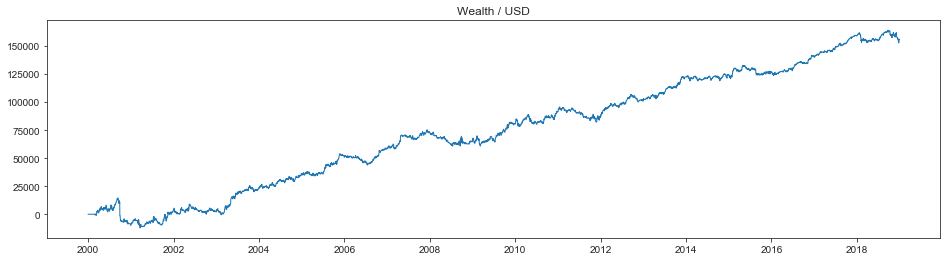

In [7]:
df_wealth = pd.DataFrame(strategy.wealth).set_index('bars')

plt.figure(figsize=(16, 4))
plt.plot(df_wealth, linewidth=1)
plt.title('Wealth / USD')
plt.show()

You can also inspect the exposure as:

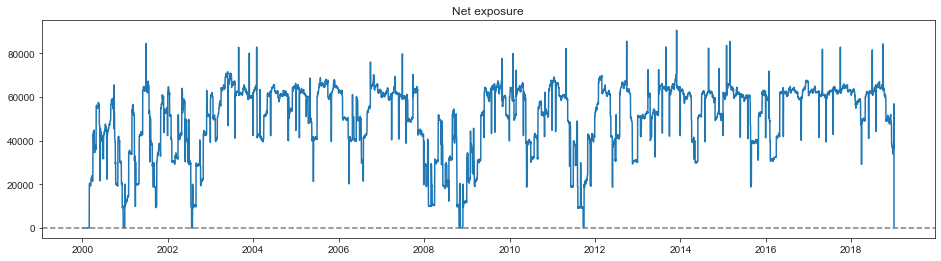

In [8]:
df_exposure = pd.Series(strategy.net_exposure, index=strategy.universe.bars)

plt.figure(figsize=(16, 4))
plt.plot(df_exposure)
plt.axhline(0, ls='--', color='gray')
plt.title('Net exposure')
plt.show()

Profit-loss distribution can be accessed by:

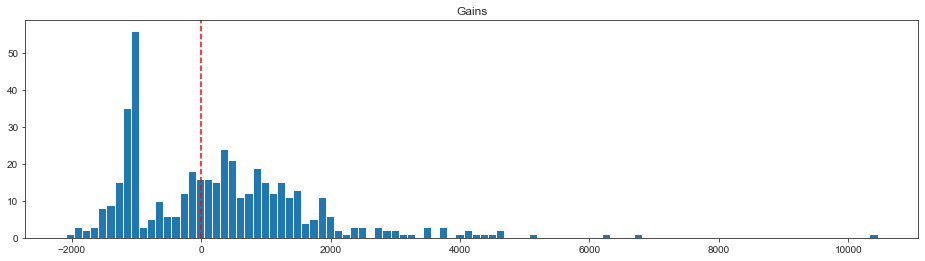

In [9]:
plt.figure(figsize=(16, 4))
plt.hist(strategy.history.gains, bins=100)
plt.axvline(0, ls='--', color='red')
plt.title('Gains')
plt.show()

Detailed trade history can be viewed as:

In [10]:
pd.DataFrame(strategy.history)

,trade_index,order_index,assets,lots,open_bars,shut_bars,atakes,acuts,close_bars,durations,open_prices,close_prices,gains
0,0,0,BRK-A,0.227273,2000-02-29,2000-05-29,10000,-1000,2000-05-29,90 days,44000.000000,57400.000000,3045.454545
1,1,1,JNJ,468.423947,2000-02-29,2000-05-29,10000,-1000,2000-05-29,90 days,21.348183,26.319628,2328.743930
2,2,2,PG,657.238799,2000-03-31,2000-06-30,10000,-1000,2000-06-30,91 days,15.215170,15.357617,93.622005
3,3,3,AMZN,149.253731,2000-03-31,2000-06-30,10000,-1000,2000-04-12,12 days,67.000000,56.375000,-1585.820896
4,4,4,MSFT,445.690370,2000-04-28,2000-07-28,10000,-1000,2000-05-25,27 days,22.437101,19.783245,-1182.798185
...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,449,449,BAC,373.987694,2018-10-31,2019-01-01,10000,-1000,2019-01-01,62 days,26.738848,24.091898,-989.926640
450,450,450,AAPL,56.973568,2018-11-30,2019-01-01,10000,-1000,2019-01-01,32 days,175.519989,155.037109,-1166.982732
451,451,451,WMT,105.050700,2018-11-30,2019-01-01,10000,-1000,2019-01-01,32 days,95.192131,91.300919,-408.774593
452,452,452,XOM,153.672778,2018-12-31,2019-01-01,10000,-1000,2019-01-01,1 days,65.073334,65.073334,0.000000
